In [1]:
import numpy as np
import tensorflow as tf
import IPython.display as ipd

In [68]:
FEAT_DIM = 1029
SP_DIM = 513
class Tanhize(object):
    ''' Normalizing `x` to [-1, 1] '''
    def __init__(self, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.xscale = xmax - xmin
    
    def forward_process(self, x):
        x = (x - self.xmin) / self.xscale
        if isinstance(x, np.ndarray):
            return np.clip(x, 0., 1.) * 2. - 1.
        elif isinstance(x, tf.tensor):
            return tf.clip_by_value(x, 0., 1.) * 2. - 1.
        else:
            raise TypeError('No such type {}'.format(type(x)))

    def backward_process(self, x):
        return (x * .5 + .5) * self.xscale + self.xmin


def read_pair(
    file_pattern,
    batch_size,
    record_lines=128,
    capacity=256,
    min_after_dequeue=128,
    num_threads=8,
    format='NCHW',
    normalizer=None,
    ):
    ''' 
    '''
    with tf.name_scope('InputSpectralFrame'):
        files = tf.gfile.Glob(file_pattern)
        filename_queue = tf.train.string_input_producer(files)

        record_bytes = FEAT_DIM * 2 * 4 * record_lines
        reader = tf.FixedLengthRecordReader(record_bytes)
        _, value = reader.read(filename_queue)
        value = tf.decode_raw(value, tf.float32)

        value = tf.reshape(value, [record_lines, 2*FEAT_DIM])
        feature = value[:,:SP_DIM]
        label = value[:,FEAT_DIM:SP_DIM+FEAT_DIM]
        
        feature = normalizer.forward_process(feature)
        label = normalizer.forward_process(label)
            
        if format == 'NCHW':
            feature = tf.reshape(feature, [-1, SP_DIM, 1])
            label = tf.reshape(label, [-1, SP_DIM, 1])
        elif format == 'NHWC':
            feature = tf.reshape(feature, [SP_DIM, -1, 1])
            label = tf.reshape(label, [SP_DIM, -1, 1])
        else:
            pass

        return tf.train.shuffle_batch(
            [feature, label],
            batch_size,
            capacity=capacity,
            min_after_dequeue=min_after_dequeue,
            num_threads=num_threads,
            allow_smaller_final_batch=True,
            # enqueue_many=True,
            )

In [69]:
def read_pair_single_numpy(
    filename,
    record_lines=256,
    normalizer=None,
    ):
    ''' 
    '''
    input_with_label = np.fromfile(filename, np.float32).reshape(-1, 2*FEAT_DIM)
    input_with_label_pad = np.zeros((record_lines,2*FEAT_DIM), np.float32)
    if input_with_label.shape[0] < record_lines:
        input_with_label_pad[:input_with_label.shape[0],:] =\
        input_with_label[:input_with_label.shape[0],:]
    else:
        input_with_label_pad[:record_lines,:] = input_with_label[:record_lines,:]
    feature, label = input_with_label_pad[:,:SP_DIM], input_with_label_pad[:,FEAT_DIM:SP_DIM+FEAT_DIM]
    if normalizer:
        feature = normalizer.forward_process(feature)
        label = normalizer.forward_process(label)
    return feature, label

In [98]:
def read_pair_batch_numpy(filenames, record_lines=256, normalizer=None):
    ''' 
    '''
    batch_inputs = [read_pair_single_numpy(filename, record_lines=record_lines, \
                                           normalizer=normalizer)[0] for filename in filenames]
    batch_labels = [read_pair_single_numpy(filename, record_lines=record_lines, \
                                           normalizer=normalizer)[1] for filename in filenames]
    return np.array(batch_inputs).astype(np.float32), np.array(batch_labels).astype(np.float32)

In [1]:
import glob
from analyzer import *
filenames = glob.glob('data/matrix_sample/225/pair/train/*.bin')

In [93]:
a = [read_pair_single_numpy(filename, normalizer=normalizer)[0] for filename in filenames]

In [3]:
a, b = read_pair_batch_numpy(filenames, record_lines=256, normalizer=normalizer)

In [14]:
np.expand_dims(a, axis=3).shape

(117, 256, 513, 1)

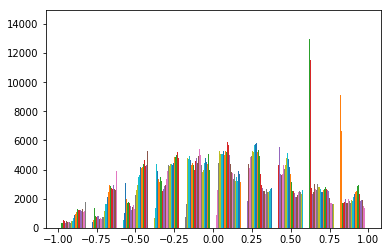

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline
_ = plt.hist(np.concatenate(a, axis=0))

In [72]:
a, b = read_pair_single_numpy('data/matrix_sample/225/pair/train/p226_001-p225_001.bin', normalizer=normalizer)

In [47]:
t = np.fromfile('data/matrix_sample/225/pair/train/p226_001-p225_001.bin', np.float32).reshape(-1, 2*FEAT_DIM)
print t.shape

(269, 2058)


In [29]:
tk = np.vstack((t,t))

In [41]:
tk[:,:1026]=0

In [50]:
test = np.hstack((np.zeros((269,513), np.float32), t[:,513:1028]))

In [77]:
a.max(), a.min(), b.max(), b.min(), a.shape, b.shape

(1.0, -1.0, 1.0, -1.0, (256, 513), (256, 513))

In [2]:
normalizer = Tanhize(
    xmax=np.fromfile('data/matrix_sample/225/etc/xmax.npf'),
    xmin=np.fromfile('data/matrix_sample/225/etc/xmin.npf'),
)

In [4]:
input_spec, label_spec = read_pair(file_pattern='./data/matrix_sample/225/pair/train/*bin',
                              batch_size=32,
                              capacity=2048,
                              min_after_dequeue=1024,
                              normalizer=normalizer,)

In [5]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
def print_shape(t):
    print(t.name, t.get_shape().as_list())

class batch_norm(object):
    """Code modification of http://stackoverflow.com/a/33950177"""
    def __init__(self, epsilon=1e-5, momentum = 0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum

            self.ema = tf.train.ExponentialMovingAverage(decay=self.momentum)
            self.name = name

    def __call__(self, x, train=True, b_reuse=False):
        shape = x.get_shape().as_list()

        if train:
            with tf.variable_scope(self.name) as scope:
                self.beta = tf.get_variable("beta", [shape[-1]],
                                    initializer=tf.constant_initializer(0.))
                self.gamma = tf.get_variable("gamma", [shape[-1]],
                                    initializer=tf.random_normal_initializer(1., 0.02))

                # work around reuse=True problem
                with tf.variable_scope(tf.get_variable_scope(), reuse=False):
                    batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments')
                    ema_apply_op = self.ema.apply([batch_mean, batch_var])
                    self.ema_mean, self.ema_var = self.ema.average(batch_mean), self.ema.average(batch_var)

                    with tf.control_dependencies([ema_apply_op]):
                        mean, var = tf.identity(batch_mean), tf.identity(batch_var)

        else:
            mean, var = self.ema_mean, self.ema_var

        normed = tf.nn.batch_norm_with_global_normalization(
                x, mean, var, self.beta, self.gamma, self.epsilon, scale_after_normalization=True)

        return normed

image_h, image_w = 128, 513
inputs = tf.placeholder(tf.float32, [None, image_h, image_w, 1], name='inputs')
labels = tf.placeholder(tf.float32, [None, image_h, image_w, 1], name='labels')

# generator section
print "GENERATOR"
print "-----------"

# not great way to create these
batch_norm_list = []
nb_residual = 15
n_extra_bn = 1
for n in range(nb_residual*2 + n_extra_bn):
    batch_norm_list.append(batch_norm(name='bn'+str(n)))

def create_generator(inputs, b_training=True):
        
    with slim.arg_scope([slim.conv2d, slim.conv2d_transpose],
                        padding='SAME',
                        activation_fn=None,
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                        weights_regularizer=slim.l2_regularizer(0.0005)):
        net = inputs
        print_shape(net)

        net = tf.nn.relu(slim.conv2d(net, 32, [3, 3], scope='gconv1'))
        print_shape(net)

        net1 = net

        res_inputs = net1
        for n in range(nb_residual):
            net = tf.nn.relu(batch_norm_list[n*2](slim.conv2d(res_inputs, 32, [3, 3], scope='conv1_res'+str(n)), train=b_training))
            net = batch_norm_list[n*2+1](slim.conv2d(net, 32, [3, 3], scope='conv2_res'+str(n)), train=b_training)
            net = net + res_inputs
            res_inputs = net


        print_shape(net)

        net = batch_norm_list[-1](slim.conv2d(net, 32, [3, 3], scope='gconv2'), train=b_training) + net1
        print_shape(net)

        # deconv
        net = tf.nn.relu(slim.conv2d_transpose(net, 128, [5, 5], stride=1, scope='deconv1'))
        print_shape(net)

        net = tf.nn.relu(slim.conv2d_transpose(net, 128, [5, 5], stride=1, scope='deconv2'))
        print_shape(net)


        # tanh since images have range [-1,1]
        net = slim.conv2d(net, 1, [3, 3], scope='gconv3', activation_fn=tf.nn.tanh)
        print_shape(net)

    return net

with tf.variable_scope("generator") as scope:
    gen = create_generator(inputs)
    scope.reuse_variables()
    gen_test = create_generator(inputs, False)

GENERATOR
-----------


In [6]:
g_loss = tf.reduce_mean(tf.square(tf.contrib.layers.flatten(create_generator(input_spec) - label_spec)))
train_vars = tf.trainable_variables()
g_vars = [var for var in train_vars if 'generator' in var.name]

g_optim = tf.train.AdamOptimizer(0.00001, beta1=0.9).minimize(g_loss, var_list=g_vars)

(u'InputSpectralFrame/shuffle_batch:0', [None, 128, 513, 1])
(u'generator/Relu:0', [None, 128, 513, 32])
(u'generator/add_14:0', [None, 128, 513, 32])
(u'generator/add_15:0', [None, 128, 513, 32])
(u'generator/Relu_16:0', [None, 128, 513, 128])
(u'generator/Relu_17:0', [None, 128, 513, 128])
(u'generator/gconv3/Tanh:0', [None, 128, 513, 1])


In [ ]:
import time
start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in xrange(30):
    
        img, anno = sess.run([input_spec, label_spec])
        print(img[0, :, :, :].shape)
        print(img[0, 0, 0, 0])
        print(img.max(), img.min())
        print(anno.max(), anno.min())

        print('current batch')

In [ ]:
import time
start_time = time.time()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)    
    for epoch in xrange(1000):
        sess.run(g_optim)
        print(epoch)
#         fetches = [g_loss, g_optim]
#         errG, _ = sess.run(fetches)    
#         print("Epoch: [%2d] time: %4.4f, g_loss: %.8f" \
#                 % (epoch, time.time() - start_time, errG))

In [6]:
label_spec

<tf.Tensor 'InputSpectralFrame/shuffle_batch:1' shape=(32, 128, 513, 1) dtype=float32>

In [87]:
import librosa

def align_specs(specfile1, specfile2, feat_dim=1026):
    distance, path = librosa.core.dtw(specfile1[:,:feat_dim].T, specfile2[:,:feat_dim].T)
    return specfile1[path[::-1,0],:], specfile2[path[::-1,1],:]

def _align_input_label(train_file, feat_dim=1026):
    input_file, label_file = train_file
    input_spec = np.fromfile(input_file, np.float32).reshape(-1,1029)
    label_spec = np.fromfile(label_file, np.float32).reshape(-1,1029)
    input_np, label_np = align_specs(input_spec, label_spec, feat_dim=feat_dim)
    return input_np, label_np

In [85]:
# NHWC and use williams code
def reader_full

AttributeError: 'Tensor' object has no attribute 'flush'

In [89]:
a, b = _align_input_label(train_map[0], feat_dim=1026)

In [49]:
input_string = tf.read_file(train_input[0])
input_decoded = tf.decode_raw(input_string, np.float32)
input_resized = tf.reshape(input_decoded, [-1, 1029])

In [50]:
input_resized

<tf.Tensor 'Reshape:0' shape=(1029,) dtype=float32>

In [72]:
sess = tf.InteractiveSession()
input_files = tf.constant(train_input)
label_files = tf.constant(train_label)

dataset = tf.data.Dataset.from_tensor_slices((input_files, label_files))
dataset = dataset.map(_parse_function)
print dataset
# print dataset[0]
# t=dataset.eval()

<MapDataset shapes: ((?, 1029), (?, 1029)), types: (tf.float32, tf.float32)>


In [56]:
t

array([[ -1.86624575e+00,  -1.86621690e+00,  -1.86614132e+00, ...,
          0.00000000e+00,   8.48128038e-05,   2.26000000e+02],
       [ -2.78762364e+00,  -2.78745246e+00,  -2.78695178e+00, ...,
          0.00000000e+00,   2.55663210e-04,   2.26000000e+02],
       [ -2.23983216e+00,  -2.23972845e+00,  -2.23941588e+00, ...,
          0.00000000e+00,   3.52880423e-04,   2.26000000e+02],
       ..., 
       [ -1.23451209e+00,  -1.22688317e+00,  -1.20457983e+00, ...,
          1.07045723e+02,   8.01121369e-02,   2.26000000e+02],
       [ -1.15902090e+00,  -1.15455484e+00,  -1.14175487e+00, ...,
          1.09877411e+02,   1.28403142e-01,   2.26000000e+02],
       [ -1.01456153e+00,  -1.01181245e+00,  -1.00363922e+00, ...,
          1.15747986e+02,   1.59915522e-01,   2.26000000e+02]], dtype=float32)

In [60]:
from analyzer import *
# import IPython.display as ipd

In [90]:
ipd.Audio(pw2wav(a), rate=16000)

In [91]:
ipd.Audio(pw2wav(b), rate=16000)